In [4]:
import os
import gradio as gr
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import TextVectorization, LSTM, Bidirectional, Dense, Embedding
from tensorflow.keras.models import Sequential
from matplotlib import pyplot as plt
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [5]:
df = pd.read_csv(os.path.join("/Users/neevgrover/Documents/SRP_23-24/jigsaw-toxic-comment-classification-challenge/", "train.csv"))

In [6]:
df.head()
#df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0020fd96ed3b8c8b,=Tony Sidaway is obviously a fistfuckee. He lo...,1,0,1,0,1,0
1,0391fa5d2ea8a52a,=-Anonymous Anti-Vandalism Vigilant Vigilante,0,0,0,0,0,0
2,063581ee63c49b08,=- this was done in an effort to correct the l...,0,0,0,0,0,0
3,06928d7e2969745b,=- unsigned comment,0,0,0,0,0,0
4,06933310fe55a295,=- Jacob Barnett\n ...,0,0,0,0,0,0


In [7]:
#Lets you see individual comments
df.iloc[3]["comment_text"]

'=- unsigned comment'

In [8]:
#.iloc lets you check the columns within an individual comment
df[df.columns[2:]].iloc[3]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 3, dtype: int64

In [9]:
#!pip list is a function that shows you what version of each package you are using

In [10]:
X = df["comment_text"]
y = df[df.columns[2:]].values

In [11]:
#Number of words in the vocab
MAX_FEATURES = 200000
#Max number of words per comment
wordcap = 1800

In [12]:
vectorizer = TextVectorization(max_tokens = MAX_FEATURES, output_sequence_length = wordcap, output_mode = "int")

In [13]:
vectorizer.adapt(X.values)

In [14]:
#Converts all the words into numbers
vectorized_text = vectorizer(X.values)
vectorized_text

<tf.Tensor: shape=(159569, 1800), dtype=int64, numpy=
array([[  2792,   8397,      9, ...,      0,      0,      0],
       [   922,   6372,  12847, ...,      0,      0,      0],
       [    14,     25,    190, ...,      0,      0,      0],
       ...,
       [ 20727,      9,      6, ...,      0,      0,      0],
       [ 39351,   4434,  12213, ...,      0,      0,      0],
       [106155,    165,      6, ...,      0,      0,      0]])>

In [15]:
#MCSHBAP - data pipelines - map, cache, shuffle, batch, prefetch - from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)#Helps prevent bottlenecks

In [16]:
#Data divided into 16 batches
len(dataset)*16

159584

In [17]:
#batch_X is the numbered characters, batch_y is if the comment is toxic, severe_toxic, etc. or not
#0 stands for not toxic, 1 stands for is toxic
batch_X, batch_y = dataset.as_numpy_iterator().next()

In [18]:
#Divide the data
train = dataset.take(int(len(dataset)*.7)) #70% for training
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2)) #.skip specifies to skip the beginning part of it (skips 70%, takes 20% more)
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1)) #skips 90%, takes the remaining 10%

In [19]:
#Amount of data per group
print(len(train) * 16)
print(len(val) * 16)
print(len(test) * 16)

111696
31904
15952


In [20]:
train_generator = train.as_numpy_iterator()
train_generator.next() #Next function runs through all the different batches one at a time each time you run it

(array([[   113,      4,     42, ...,      0,      0,      0],
        [    29,   1806,      9, ...,      0,      0,      0],
        [  2906,  20311,     98, ...,      0,      0,      0],
        ...,
        [    46,    168,     21, ...,      0,      0,      0],
        [   523,     50,     64, ...,      0,      0,      0],
        [108288,   5081,     88, ...,      0,      0,      0]]),
 array([[1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0]]))

In [21]:
model = Sequential() #Gets the Sequential API
model.add(Embedding(MAX_FEATURES + 1, 32)) #Create the embedding layer (1 per word, 32 values in length)
model.add(Bidirectional(LSTM(32, activation = "tanh"))) #32 LSTM layers, bidirectional
#Ex: I don't hate you: Bidirectional will see the don't and will realize it is non-toxic
#Feature extractor fully connected layers
model.add(Dense(128, activation = "relu"))
model.add(Dense(256, activation = "relu"))
model.add(Dense(128, activation = "relu"))
#Final layer
model.add(Dense(6, activation = "sigmoid")) #6 stands for 6 outputs

In [22]:
model.compile(loss="BinaryCrossentropy", optimizer = "Adam")

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
#Train the Model
#Increase number of epochs for better results
history = model.fit(train, epochs = 5, validation_data = val)

Epoch 1/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 14486s 2s/step - loss: 0.0822 - val_loss: 0.0454
Epoch 2/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2519s 361ms/step - loss: 0.0466 - val_loss: 0.0404
Epoch 3/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2498s 358ms/step - loss: 0.0416 - val_loss: 0.0366
Epoch 4/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2525s 362ms/step - loss: 0.0367 - val_loss: 0.0331
Epoch 5/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2396s 343ms/step - loss: 0.0326 - val_loss: 0.0287


In [25]:
#Make Predictions

In [26]:
batch = test.as_numpy_iterator().next()

In [27]:
input_text = vectorizer("You freaking suck! I am going to hit you.")

In [28]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [29]:
model.predict(np.expand_dims(input_text, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


array([[0.9951817 , 0.19072917, 0.9761004 , 0.0516224 , 0.9086    ,
        0.14400953]], dtype=float32)

In [30]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [31]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [32]:
batch_y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [33]:
res = model.predict(np.expand_dims(input_text, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [34]:
#Evaluate Model

In [35]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [36]:
for batch in test.as_numpy_iterator():
    #Unpack the batch
    X_true, y_true = batch
    #Make a prediction
    yhat = model.predict(X_true)
    #Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

2024-10-14 20:05:32.432588: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [37]:
print(f"Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}")

Precision: 0.8629575371742249, Recall: 0.8451390862464905, Accuracy: 0.5065195560455322


In [48]:
#Test and Gradio

In [50]:
#Save the model
model.save("/Users/neevgrover/Documents/SRP_23-24/test_204.h5")

In [51]:
model = tf.keras.models.load_model("/Users/neevgrover/Documents/SRP_23-24/test_204.h5")

In [52]:
input_str = vectorizer("I will kill you")

In [53]:
model.predict(np.expand_dims(input_str, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


array([[0.972538  , 0.1896219 , 0.38687846, 0.24103948, 0.45408073,
        0.60624397]], dtype=float32)

In [54]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    text = ""
    for idx, col in enumerate(df.columns[2:]):
        text += "{}: {}\n".format(col, results[0][idx]>0.5)
    return text

In [55]:
inputs = gr.Textbox(lines = 2, placeholder = "Enter Comment Here")
interface = gr.Interface(fn = score_comment, inputs = inputs, outputs = "text")

In [60]:
#Share = true makes it publicily available for a short period of time
#interface.close() to turn off and rerun
interface.launch(share = True)
#interface.close()

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
Running on public URL: https://fe558c6ddeb89dcc0f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


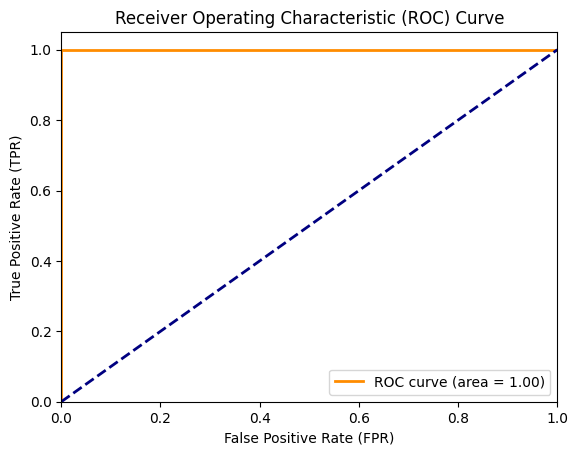

In [57]:
#Make a Precision Recall Graph
#y_true and yhat are your true labels and predicted scores
fpr, tpr, _ = roc_curve(y_true, yhat)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

<Figure size 800x500 with 0 Axes>

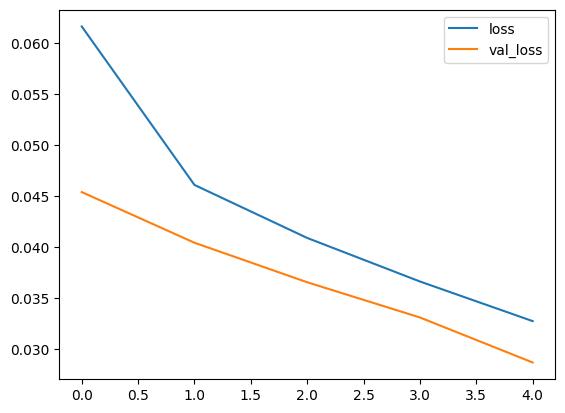

In [58]:
#Loss and val_loss graph
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()